# Heart Disease Prediction with Logistic Regression<a id='top'></a>
&emsp;A dataset from [UC Irvine Machine Learning Respository](https://archive.ics.uci.edu/dataset/45/heart+disease) is used to train a heart disease prediction model using Logistic Regression. Fourteen attributes from original 76 are available for training. They will be examined about the effectiveness of predicting and relationship with the response variable ranging from 0 (absence of heart disease) to 4 (different categories of presence heart disease). The published accuracy of logistic regression reaches up to **89.474%** and **91.108%** for precision.

In [1]:
from ucimlrepo import fetch_ucirepo
# import dataset
heart_disease = fetch_ucirepo(id=45)
# alternatively: fetch_ucirepo(name='Heart Disease')

# access data
X = heart_disease.data.features
y = heart_disease.data.targets

# Libraries
# Array & dataframe
import numpy as np
import pandas as pd
# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns
# Modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

The available predictors are listed as follows.

In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


Remarks:  
* **cp**: Chest pain types  
* **trestbps**: resting blood pressure  
* **chol**: serum cholestoral in mg/dl  
* **fbs**: fasting blood sugar  
* **restecg**: resting electrocardiographic results  
* **thalach**: maximum heart rate achieved  
* **exang**: exercise induced angina  
* **oldpeak**: ST depression induced by exercise relative to rest  
* **slope**: the slope of the peak exercise ST segment  
* **ca**: number of major vessels colored by flourosopy
* **thal**: thalassemia

&emsp;For the preliminary model, response variable is converted into 2 classes, absence and presence of heart disease.

In [3]:
y.value_counts(dropna=False)

num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64

In [4]:
y = y['num'].apply(lambda x: 0 if x==0 else 1)
y.value_counts(dropna=False)

num
0    164
1    139
Name: count, dtype: int64

# Table of Contents<a id='toc'></a>
1. [Data Exploration](#explore)  
&emsp;1.1 [Missing Values](#missing)  
&emsp;1.1 [Categorical Features](#explore-cat)  
&emsp;1.2 [Numeric Features](#explore-num)  
2. [Data Preprocessing](#preprocess)
3. [Model Training](#train)  
&emsp;3.1 [Preliminary Model (Saturated)](#saturated)  
&emsp;3.2 [Validation on Saturated Model](#valid-saturated)  
&emsp;3.3 [Model Calibration](#calibrate)

# Data Exploration<a id='explore'></a>

In [5]:
# Check missing values
print(X.isna().sum())
print(y.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64
0


## Missing Values<a id='missing'></a>

In [6]:
# index with missing values
index_na = X.loc[X.isna().sum(axis=1) > 0,:].index
pd.concat([X.iloc[index_na,:], y.iloc[index_na]], axis=1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


Since the number of instances is not plenty, imputations will be made to the rows with missing values.

In [7]:
# Indexes with 1 as response
y1_ind = y[y==1].index
print("Mean value of feature 'ca' for response 1:", X.loc[y1_ind,:]['ca'].mean())
print(X.loc[y1_ind,:]['ca'].value_counts())
print("Mean value of feature 'thal' for response 1:", X.loc[y1_ind,:]['thal'].mean())
print(X.loc[y1_ind,:]['thal'].value_counts())

# Indexes with 0 as response
y1_ind = y[y==0].index
print("Mean value of feature 'ca' for respponse 0:", X.loc[y1_ind,:]['ca'].mean())
print(X.loc[y1_ind,:]['ca'].value_counts())
print("Mean value of feature 'thal' for response 0:", X.loc[y1_ind,:]['thal'].mean())
print(X.loc[y1_ind,:]['thal'].value_counts())

Mean value of feature 'ca' for response 1: 1.1376811594202898
ca
0.0    46
1.0    44
2.0    31
3.0    17
Name: count, dtype: int64
Mean value of feature 'thal' for response 1: 5.840579710144928
thal
7.0    89
3.0    37
6.0    12
Name: count, dtype: int64
Mean value of feature 'ca' for respponse 0: 0.2732919254658385
ca
0.0    130
1.0     21
2.0      7
3.0      3
Name: count, dtype: int64
Mean value of feature 'thal' for response 0: 3.7975460122699385
thal
3.0    129
7.0     28
6.0      6
Name: count, dtype: int64


Missing value of feature **ca** will be replaced by the closest categorial value to the mean which is 1 whereas 6 for **thal** for response 1.  0 and 3 for response 0.

In [8]:
X.loc[192,'ca'] = 1
X.loc[266,'thal'] = 6
X.loc[[166,287,302],'ca'] = 0
X.loc[87,'thal'] = 3

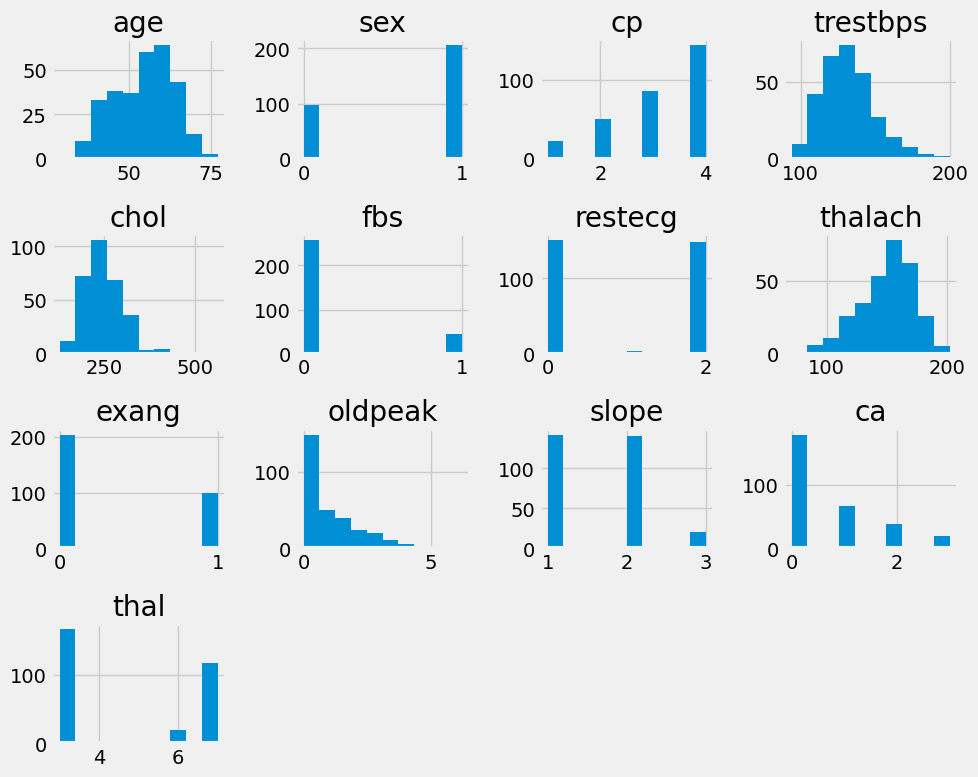

In [9]:
# Visualize distribution of features
X.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

As shown in the distribution plot and the feature description provided, the following features are categorical values...  
* **sex**  
* **cp** (Chest pain types)  
* **fbs** (1 when fasting blood sugar > 120 mg/dl; 0 otherwise)  
* **restecg** (resting electrocardiographic results where 1 or 2 indicate anomalies; 0 means normal)  
* **exang** (1 for exercise induced angina; 0 otherwise)  
* **slope** (the slope of the peak exercise ST segment)  
* **ca** (number of major vessels colored by flourosopy)
* **thal** (thalassemia)  

The distributions of individuals from two groups, absence and presence of heart disease, for all features are compared. If difference is obvious for a feature, that feature can be a good predictor for the model.

## Categorical Features<a id='explore-cat'></a>

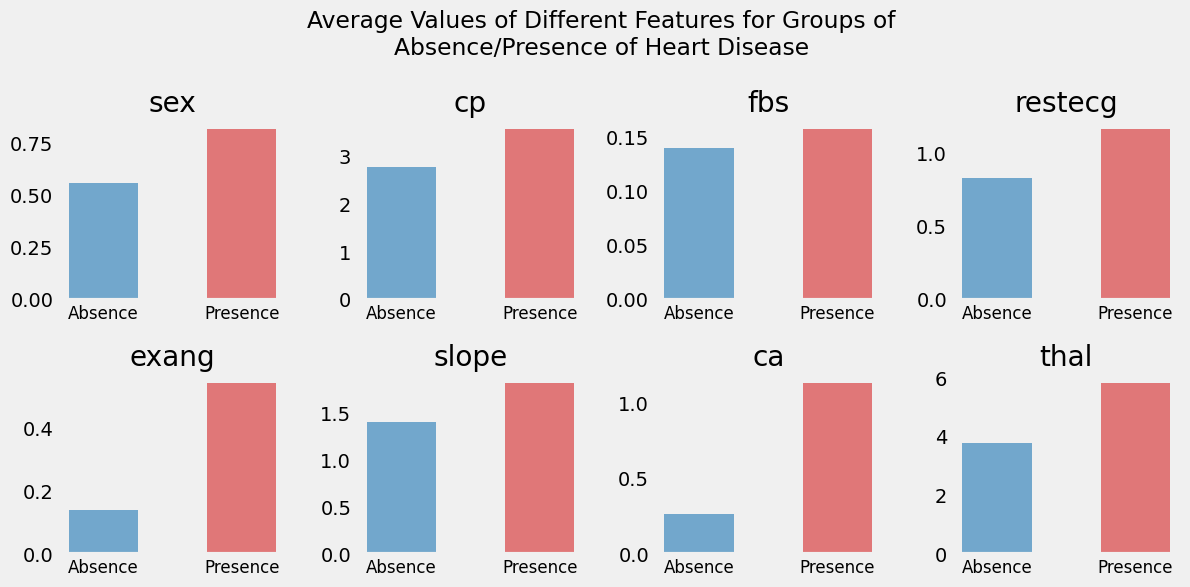

In [10]:
# Visualize distribution based on response variable for categorical features
cats = ['sex', 'cp', 'fbs', 'restecg', 'exang' ,'slope', 'ca', 'thal']
# Combine predictors and response dataset for aggregation
Xy = pd.concat([X, y], axis=1)
# Group by response variable and calculate mean for each categorical feature
cat_groups = Xy.groupby('num').agg(
    {
        "sex":"mean",
        "cp":"mean",
        "fbs":"mean",
        "restecg":"mean",
        "exang":"mean",
        "slope":"mean",
        "ca":"mean",
        "thal":"mean"
    }
).reset_index(drop=True)

# Visualize 
fig, axes = plt.subplots(2,4, figsize=(12,6))
for i in range(len(cats)):
    ax = axes.ravel()[i]
    ax.bar([0,1], cat_groups.iloc[:,i], width=.5, color=['tab:blue','tab:red'], alpha=.6)
    ax.set_title(cat_groups.columns[i])
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Absence','Presence'], fontsize=12)
    ax.grid(False)
fig.suptitle('Average Values of Different Features for Groups of\nAbsence/Presence of Heart Disease')
fig.tight_layout()
plt.show()


&emsp;The graph points out whether the difference in average values of all categorical features is visually significant. The meaning of values (y-axis) at this point is not important. The focus of the graph is to identify promising categorical features which would be useful for training a model. For instance, for feature **exang** (exercise induced angina), visually there is a great difference in the height of the bars. In other words, an individual with higher value in **exang** would have more probability to have heart disease while keeping all other features constant.  

&emsp;Based on the graph, the usefulness of features are listed as follows in descending order approximately by visual:  
1. ca
2. exang
3. thal
4. sex
5. restecg
6. cp
7. slope
8. fbs  

&emsp;Later on during model training, features with higher ranking will be prioritized.

## Numeric Features<a id='explore-num'></a>

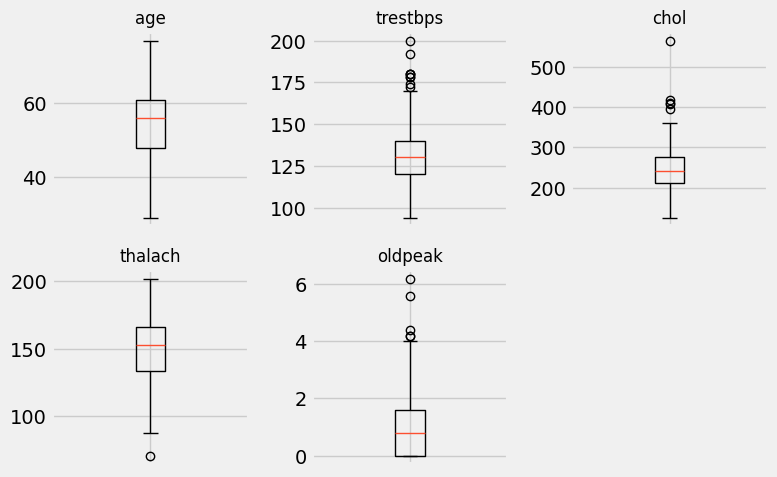

In [11]:
# Numeric features
num = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
# Outliers examination
fig, axes = plt.subplots(2,3, figsize=(8,5))
for i in range(6):
    ax = axes.ravel()[i]
    try:
        ax.boxplot(X[num[i]])
        ax.set_title(num[i], fontsize=12)
        ax.set_xticklabels([])
    except IndexError:
        ax.grid(False)
        ax.set_yticks([])
        ax.set_xticks([])
fig.tight_layout()
plt.show()


The outliers in  
* **trestbps (resting blood pressure)**,  
* **chol (serum cholestoral in mg/dl)**, and  
* **oldpeak ST depression induced by exercise relative to rest**  

appear to be valid. Models with and without outliers would be compared to review the effect. Apart from outliers, these 3 features are transformed by logarithm to improve their normalities.

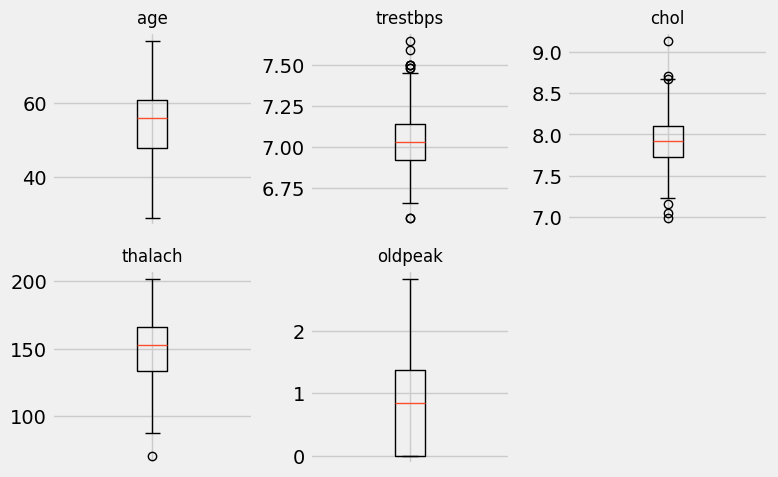

In [12]:
num_trans = X.loc[:,num]

outliers = ['trestbps', 'chol', 'oldpeak']
for o in outliers:
    num_trans[o] = num_trans[o].apply(lambda x: np.log2(x+1))
        
fig, axes = plt.subplots(2,3, figsize=(8,5))
for i in range(6):
    ax = axes.ravel()[i]
    try:
        ax.boxplot(num_trans.iloc[:,i])
        ax.set_title(num_trans.columns[i], fontsize=12)
        ax.set_xticklabels([])
    except IndexError:
        ax.grid(False)
        ax.set_yticks([])
        ax.set_xticks([])
fig.tight_layout()
plt.show()

The distributions seem more centered than before.

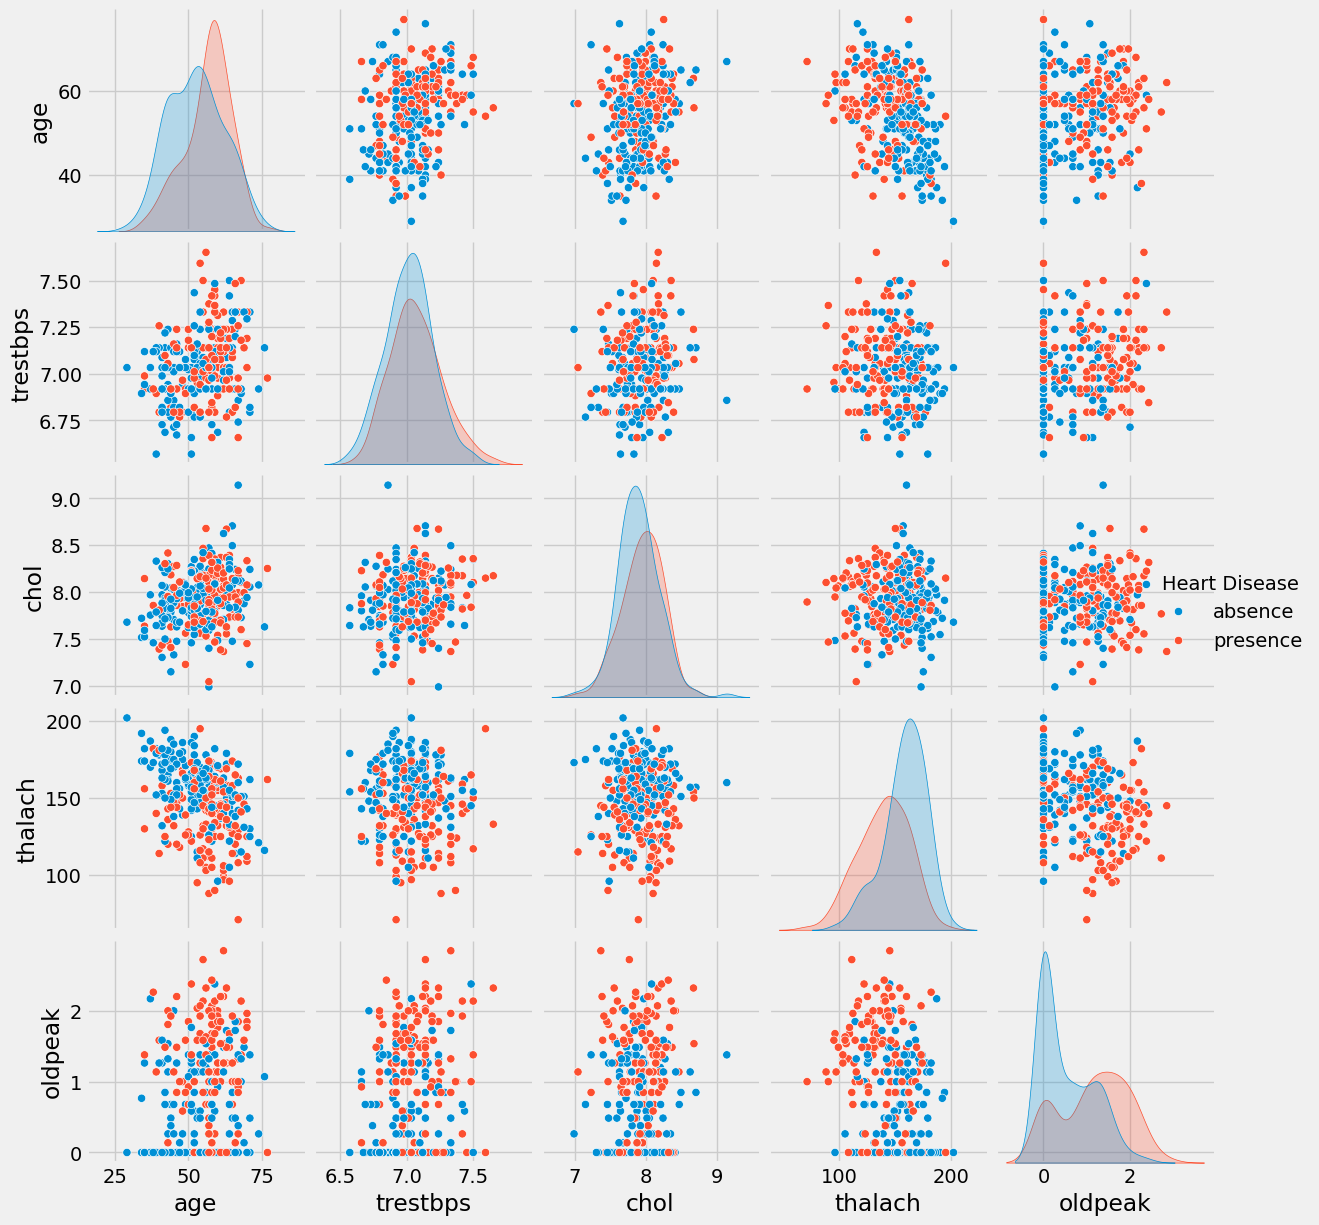

In [13]:
# Combine and review transformed features' distributions by groups of absence and presence of heart disease
num_trans_y = pd.concat([num_trans, y], axis=1)
pp = sns.pairplot(num_trans_y, hue='num')
pp.legend.set_title("Heart Disease")
legends = ['absence', 'presence']
for t, l in zip(pp.legend.texts, legends):
    t.set_text(l)
plt.show()

The relationships among numeric features are shown in scatterplots and distributions of two groups (*absence* and *presence* of heart disease) for each numeric feature are displayed in the diagonal plots.  

* The *absence* and *presence* groups distributions appear to have little difference for features **trestbps** and **chol**  
* Visually there are some difference in the distributions for features **age**, **thalach**, and **oldpeak**.  
* However by looking at the scatterplot of **age** and **thalach**, there seems to be a negative relationship.  

Consequently, **oldpeak** and either **age** and **thalach** will be prioritized for training as they show dependency.

# Data Preprocessing<a id='preprocess'></a>

For the preliminary training, a **saturated** model is adopted. Before model training, categorical features are converted into dummy variables while numeric features are normalized using Min-Max scaler using training set.

In [14]:
cats = ['ca', 'exang', 'thal', 'sex', 'restecg', 'cp', 'slope', 'fbs']
cat_dummies = pd.get_dummies(X[cats], columns=cats, drop_first=True, dtype=int)
cat_dummies.head(2)

,ca_1.0,ca_2.0,ca_3.0,exang_1,thal_6.0,thal_7.0,sex_1,restecg_1,restecg_2,cp_2,cp_3,cp_4,slope_2,slope_3,fbs_1
0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1
1,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0


In [15]:
# Combine numeric and categorical features into final X
X_all = pd.concat([num_trans, cat_dummies], axis=1)
print(X_all.shape)
X_all.head(2)

(303, 20)


,age,trestbps,chol,thalach,oldpeak,ca_1.0,ca_2.0,ca_3.0,exang_1,thal_6.0,thal_7.0,sex_1,restecg_1,restecg_2,cp_2,cp_3,cp_4,slope_2,slope_3,fbs_1
0,63,7.189825,7.870365,150,1.722466,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1
1,67,7.330917,8.164907,108,1.321928,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0


In [16]:
# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=.2, random_state=4)
print("train:", y_train.value_counts())
print("test:", y_test.value_counts())
# Normalize numeric features
mscaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(mscaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(mscaler.transform(X_test), columns=X_test.columns)

train: num
0    132
1    110
Name: count, dtype: int64
test: num
0    32
1    29
Name: count, dtype: int64


# Model Training<a id='train'></a>

In [17]:
# Model fitting using training set
lm = LogisticRegression()
lm.fit(X_train_scaled, y_train)

LogisticRegression()

## Preliminary Model (Saturated)<a id='saturated'></a>

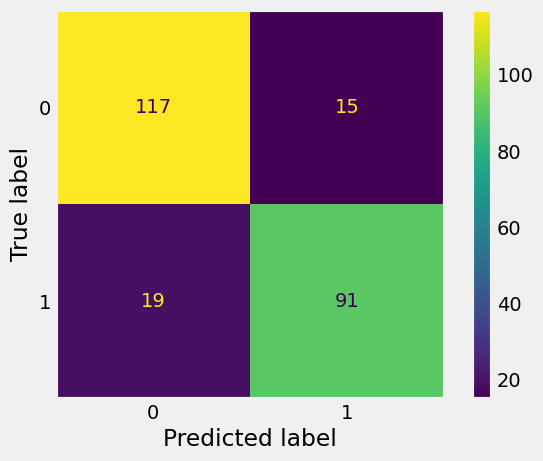

Accuracy: 85.95 %
Sensitivity: 82.73 %
Specificity: 88.64 %


In [18]:
# Model evaluation
def metrics(model, X, y, display=True):
    # Overall accuracy
    y_pred = model.predict(X)
    accuracy = round(accuracy_score(y, y_pred)*100, 2)
    # Sensitivity
    tp = sum((y==1) & (y_pred==1))
    fn = sum((y==1) & (y_pred==0))
    sensitivity = round(100 * tp / (tp + fn), 2)
    # Specificity
    tn = sum((y==0) & (y_pred==0))
    fp = sum((y==0) & (y_pred==1))
    specificity = round(100 * tn / (tn + fp), 2)
    # Display confusion matrix
    if display==True:
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, y_pred)).plot()
        plt.grid(False)
        plt.show()
        # Print all metrics
        print("Accuracy:", accuracy, "%")
        print("Sensitivity:", sensitivity, "%") 
        print("Specificity:", specificity, "%")
    return accuracy, sensitivity, specificity

acc_train, sens_train, spec_train = metrics(lm, X_train_scaled, y_train)

&emsp;The overall accuracy of 85.95% is good. However, since heart disease is a serious medical condition where immediate attention is needed or at least recommended, having sensitivity of 82.73% is not desirable. It means for 100 individuals with presence of heart disease, only about 82 of them are predicted as having heart disease wheres other 18 individuals actually having heart disease would be predicted as absence of heart disease. It would cause delayed treatment and consequently detrimental health effect to the individuals.  

&emsp;Due to the unsatisfactory performance, outliers are removed then a second model is trained without outliers.

train: num
0    134
1    106
Name: count, dtype: int64
test: num
1    32
0    29
Name: count, dtype: int64


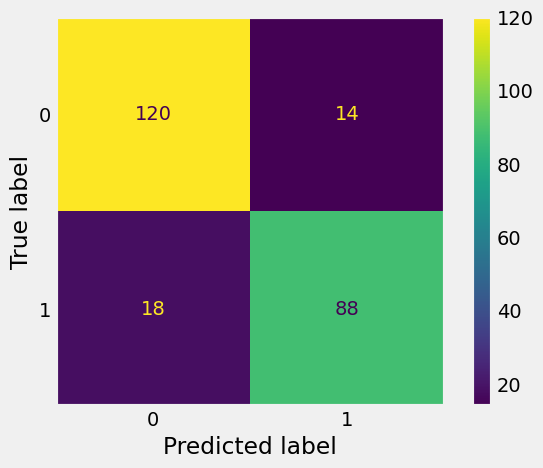

Accuracy: 86.67 %
Sensitivity: 83.02 %
Specificity: 89.55 %


In [19]:
# New categorical set
cats = ['ca', 'exang', 'thal', 'sex', 'restecg', 'cp', 'slope', 'fbs']
cat_dummies = pd.get_dummies(X[cats], columns=cats, drop_first=True, dtype=int)
cat_dummies.head(2)
# Combine numeric and categorical features into final X
X_all = pd.concat([num_trans, cat_dummies], axis=1)
X_all_out = X_all[ ((np.abs(X_all['trestbps']) - X_all['trestbps'].mean()) <= (X_all['trestbps'].std() * 3)) & ((np.abs(X_all['chol']) - X_all['chol'].mean()) <= (X_all['chol'].std() * 3)) ]
indexes = X_all[ ~(((np.abs(X_all['trestbps']) - X_all['trestbps'].mean()) <= (X_all['trestbps'].std() * 3)) & ((np.abs(X_all['chol']) - X_all['chol'].mean()) <= (X_all['chol'].std() * 3))) ].index
y_out = y.drop(index=indexes)

# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all_out, y_out, test_size=.2, random_state=4)
print("train:", y_train.value_counts())
print("test:", y_test.value_counts())
# Normalize numeric features
mscaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(mscaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(mscaler.transform(X_test), columns=X_test.columns)
# Model fitting using training set without outliers
lm2 = LogisticRegression()
lm2.fit(X_train_scaled, y_train)
# Evaluation for training data
acc_train2, sens_train2, spec_train2 = metrics(lm2, X_train_scaled, y_train)

In [20]:
# Metrics difference
print("Accuracy Change:", round(acc_train2 - acc_train, 2), "%")
print("Sensitivity Change:", round(sens_train2 - sens_train, 2), "%")
print("Specificity Change:", round(spec_train2 - spec_train, 2), "%")

Accuracy Change: 0.72 %
Sensitivity Change: 0.29 %
Specificity Change: 0.91 %


&emsp;The effect of outliers removal improved the performance slightly in general. However, since the model is a saturated with all given features, it is prone to overfitting. In the following, validation with test data will be performed.

## Validation on Saturated Model<a id='valid-saturated'></a>

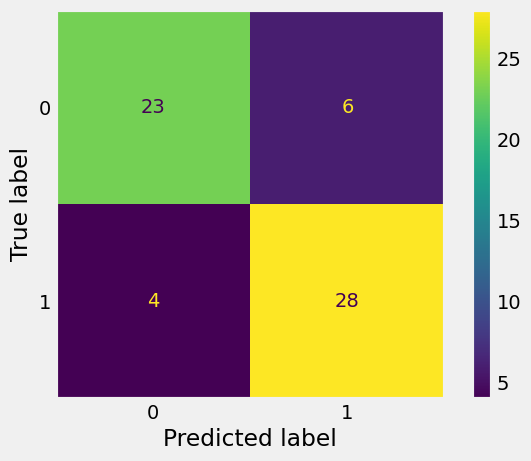

Accuracy: 83.61 %
Sensitivity: 87.5 %
Specificity: 79.31 %


In [21]:
acc_test, sens_test, spec_test = metrics(lm2, X_test_scaled, y_test)

&emsp;Validation indicates possible over-fitting as **overall accuracy** reduced slightly and **specificity** dropped by 10%. However, **sensitivity** increased which could be caused by pure chance. Reduction in number of features may ressolve the problem and even improve the model with less noises in the dataset. Additionally, oversampling for instances with response variable 1 and undersampling for instances with response variable 0 may also help increase sensitivity.

## Model Calibration<a id='calibrate'></a>

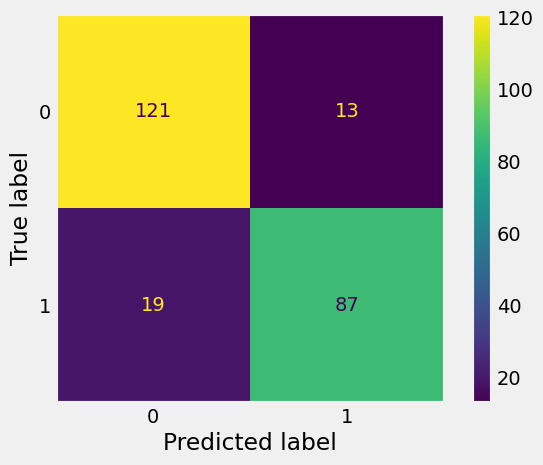

Accuracy: 86.67 %
Sensitivity: 82.08 %
Specificity: 90.3 %


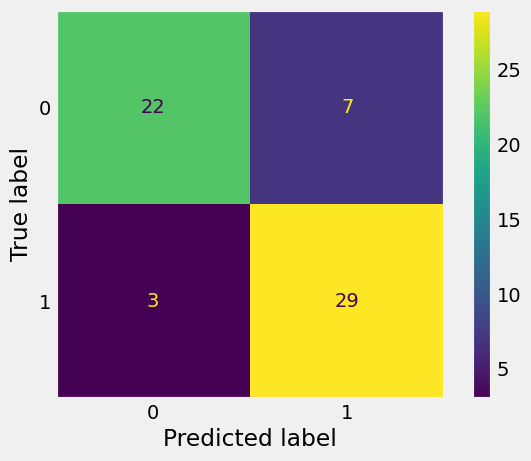

Accuracy: 83.61 %
Sensitivity: 90.62 %
Specificity: 75.86 %


In [22]:
lm_l1 = LogisticRegression(penalty='l1', solver='liblinear')
lm_l1.fit(X_train_scaled, y_train)

acc_train_l1, sens_train_l1, spec_train_l1 = metrics(lm_l1, X_train_scaled, y_train)
acc_test_l1, sens_test_l1, spec_test_l1 = metrics(lm_l1, X_test_scaled, y_test)

&emsp;Regularization with LASSO regression seems to perform better in in terms of sensitivity. LASSO regression will be adopted for the following modelling. Now, models with one feature at a time will be trained and compared to see the performance of each predictors. Finally, models are again trained from saturated to the best performing predictor according to the performance ranking of the predictors.

In [23]:
# Dictionary to store performance of each predictor
predictors = {}
# Performance from models with each predictor
for p in X_train_scaled.columns:
    lm_l1.fit(X_train_scaled[[p]], y_train)
    performance = metrics(lm_l1, X_test_scaled[[p]], y_test, display=False)
    predictors[p] = performance[0]
# Sort by overall accuracy
predictors_sorted = sorted(predictors, key=predictors.get, reverse=True)
predictors_sorted

['oldpeak',
 'cp_4',
 'cp_3',
 'thalach',
 'thal_7.0',
 'ca_2.0',
 'slope_2',
 'exang_1',
 'sex_1',
 'restecg_2',
 'ca_1.0',
 'age',
 'thal_6.0',
 'trestbps',
 'ca_3.0',
 'chol',
 'restecg_1',
 'cp_2',
 'slope_3',
 'fbs_1']

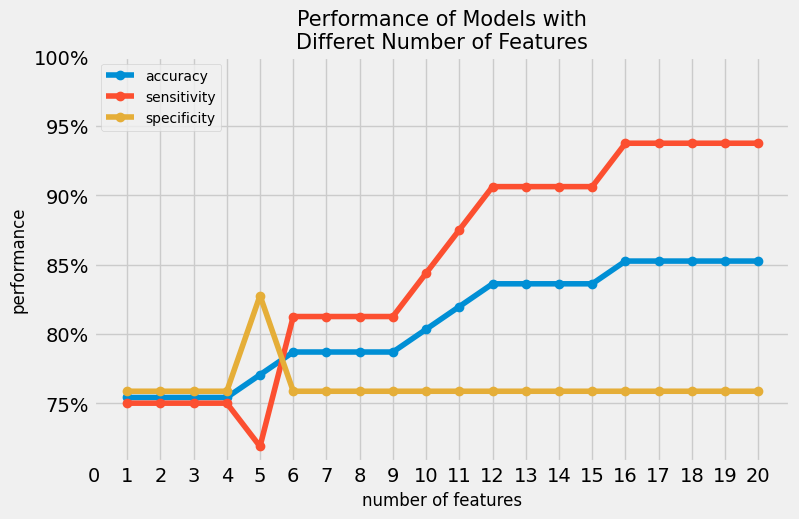

In [96]:
# Performance from models with saturated models to single predictor model
models_acc = {}
models_sens = {}
performances = {}
for i in range(len(X_train_scaled.columns)-1, -1, -1):
    if i != 0:
        lm_l1.fit(X_train_scaled[predictors_sorted[:i]], y_train)
        performance = metrics(lm_l1, X_test_scaled[predictors_sorted[:i]], y_test, display=False)
    else:
        lm_l1.fit(pd.DataFrame(X_train_scaled[predictors_sorted[0]]), y_train)
        performance = metrics(lm_l1, pd.DataFrame(X_test_scaled[predictors_sorted[0]]), y_test, display=False)
    models_acc[i+1] = performance[0]
    models_sens[i+1] = performance[1]
    performances[i+1] = performance
    
# Sort by overall accuracy
models_acc_sorted = sorted(models_acc, key=models_acc.get, reverse=True)
# Sort by sensitivity
models_sens_sorted = sorted(models_sens, key=models_sens.get, reverse=True)

# Display
performances_df = pd.DataFrame.from_dict(performances, orient='index', columns=['accuracy', 'sensitivity', 'specificity'])
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(performances_df.index, 'accuracy', data=performances_df, marker='o', label='accuracy')
ax.plot(performances_df.index, 'sensitivity', data=performances_df, marker='o', label='sensitivity')
ax.plot(performances_df.index, 'specificity', data=performances_df, marker='o', label='specificity')
ax.set_xticks(range(0,21))
ax.set_xlabel("number of features", fontsize=12)
ax.set_yticks([75,80,85,90,95,100])
ax.set_yticklabels([f'{y}%' for y in ax.get_yticks()])
ax.set_ylabel("performance", fontsize=12)
ax.legend(fontsize=10, loc='upper left')
ax.set_title("Performance of Models with\nDifferet Number of Features", fontsize=15)
plt.show()

In [28]:
models_acc_sorted

[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [29]:
models_sens_sorted

[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 4, 3, 2, 1, 5]

In [52]:
models_sens[20]

93.75

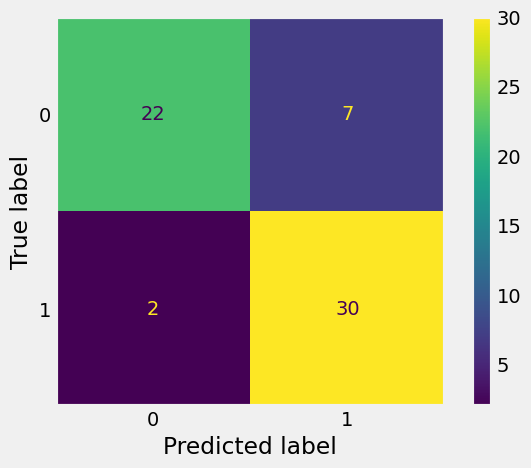

Accuracy: 85.25 %
Sensitivity: 93.75 %
Specificity: 75.86 %


(85.25, 93.75, 75.86)

In [59]:
lm_l1.fit(X_train_scaled[predictors_sorted[:18]], y_train)
metrics(lm_l1, X_test_scaled[predictors_sorted[:18]], y_test)

In [47]:
predictors_sorted[:20]

['oldpeak',
 'cp_4',
 'cp_3',
 'thalach',
 'thal_7.0',
 'ca_2.0',
 'slope_2',
 'exang_1',
 'sex_1',
 'restecg_2',
 'ca_1.0',
 'age',
 'thal_6.0',
 'trestbps',
 'ca_3.0',
 'chol',
 'restecg_1',
 'cp_2',
 'slope_3',
 'fbs_1']